In [28]:
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta, UTC
import boto3
from botocore.config import Config
import matplotlib.pyplot as plt

In [29]:
# Replace with your Polygon.io API key
API_KEY = 'HNZE4DAvb4z5ux2asvBKz_1WGusD_PIR'
aws_access_key_id='0f2fcb6c-d38d-4862-b4d7-8955288d5c11'
aws_secret_access_key='HNZE4DAvb4z5ux2asvBKz_1WGusD_PIR'
SYMBOLS = ["AAPL", "MSFT", "AMZN", "NVDA", "TSLA"]
    #, "GOOGL",  "META",\
    #      "UNH", "V", "XOM", "JPM", "JNJ", "WMT", "MA", "PG", "CVX", "HD", "LLY", "ABBV", \
     #    "BAC", "MRK", "AVGO", "KO", "ORCL", "PEP", "PFE", "TMO", "COST", "QQQ", "CRWD", "TTD"]
interval = "1m"
days_of_data = 30 

In [30]:
SEQ_LEN = 60  # 60 minutes
BIZ_DAYS = 7
INTERVALS_PER_DAY = 390  # 1-min trading intervals

#DEVICE = 'xpu' if torch.xpu.is_available() else 'cpu';
DEVICE='cpu'
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


In [ ]:
session = boto3.Session(
  aws_access_key_id=aws_access_key_id,
  aws_secret_access_key=aws_secret_access_key
)

In [ ]:
s3 = session.client(
  's3',
  endpoint_url='https://files.polygon.io',
  config=Config(signature_version='s3v4'),
)

In [31]:
def prepare_sequences(df, scaler, seq_len):
    scaled = scaler.fit_transform(df)
    X, y = [], []
    for i in range(seq_len, len(scaled)-1):
        X.append(scaled[i-seq_len:i])
        y.append(scaled[i][0])  # Close
    return np.array(X), np.array(y)


In [32]:
def fetch_polygon_data(symbol, days):
    print(f'symbol {symbol}')
    end = datetime.now(UTC)
    start = end - timedelta(days=days_of_data)
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/minute/{start.date()}/{end.date()}?adjusted=true&sort=asc&limit=50000&apiKey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data["results"])
    df["t"] = pd.to_datetime(df["t"], unit="ms")
    df.set_index("t", inplace=True)
    df.rename(columns={"o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"}, inplace=True)
    new_column_order = ['Close','Open','High', 'Low','Volume']
    df = df[new_column_order]
    return df

In [33]:
def add_indicators(df):
    df = df.copy()
    df["macd"] = MACD(df["Close"]).macd()
    df["rsi"] = RSIIndicator(df["Close"]).rsi()
    bb = BollingerBands(df["Close"])
    df["bb_mavg"] = bb.bollinger_mavg()
    df["bb_high"] = bb.bollinger_hband()
    df["bb_low"] = bb.bollinger_lband()
    return df.dropna()
# "['bb_mavg', 'bb_high', 'bb_low']

In [34]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=640, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)             # out: (batch_size, seq_len, hidden_dim)
        last_time_step = out[:, -1, :]    # could also pool over time
        return self.fc(last_time_step)


In [40]:
X_all, y_all = [], []
scaler = MinMaxScaler()
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'macd', 'rsi', 'bb_mavg', 'bb_high', 'bb_low']

for symbol in SYMBOLS:
    df = fetch_polygon_data(symbol, days=25)
    df = add_indicators(df)
    X, y = prepare_sequences(df[features], scaler, SEQ_LEN)
    X_all.append(X)
    y_all.append(y)

X = np.concatenate(X_all)
y = np.concatenate(y_all)

num_cols = X.shape[1]

# Generate a random permutation of column indices
col_permutation = np.random.permutation(num_cols)
print(col_permutation[0].shape)
# Apply the permutation to scramble the columns of X and y
X = X[:, col_permutation]
y = y[:, col_permutation[0]]


symbol AAPL
symbol MSFT
symbol AMZN
symbol NVDA
symbol TSLA
()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# Split into train/test
test_steps = INTERVALS_PER_DAY * BIZ_DAYS
X_train, y_train = X[:-test_steps], y[:-test_steps]
X_test, y_test = X[-test_steps:], y[-test_steps:]

X_train = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(DEVICE)
X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)


In [ ]:
torch.xpu.init()
torch.xpu.reset_peak_memory_stats()
torch.xpu.reset_accumulated_memory_stats()
# torch.xpu.empty_cache()

In [ ]:
# ---------------------
# TRAINING
# ---------------------
model = LSTMModel(input_dim=X.shape[2]).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 30
model.train()
for epoch in range(epochs):
    output = model(X_train)
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # torch.xpu.empty_cache()
    print(f"Epoch {epoch+1} Loss: {loss.item():.6f}")


In [ ]:
model.eval()
with torch.no_grad():
    pred_test = model(X_test).cpu().numpy().flatten()
    future_preds = []
    
    seq = X_test[-1].unsqueeze(0)
    for _ in range(test_steps):
        npred = model(seq)
        future_preds.append(npred.item())
    
        # Build next input
        last_features = seq[:, -1, 1:].detach()  # remove close
        new_point = torch.cat([npred, last_features], dim=-1)  # shape: (1, input_dim)
        new_point = new_point.unsqueeze(1)  # shape: (1, 1, input_dim)
    
        # Slide window and append
        seq = torch.cat([seq[:, 1:, :], new_point], dim=1)

In [ ]:
# -----------------------
future_steps = 7 * 270
last_seq = X_test[-1:].clone()
future_preds = []

model.eval()
with torch.no_grad():
    for _ in range(future_steps):
        next_pred = model(last_seq)
        future_preds.append(next_pred.item())

        # Fix dimension mismatch here
        pred_close = next_pred.squeeze()                    # scalar
        last_feats = last_seq[:, -1, 1:].squeeze(0)         # (input_dim - 1,)
        next_input = torch.cat([pred_close.unsqueeze(0), last_feats], dim=0)  # (input_dim,)
        next_input = next_input.unsqueeze(0).unsqueeze(0)   # (1, 1, input_dim)

        # Slide window
        last_seq = torch.cat([last_seq[:, 1:, :], next_input], dim=1)


In [ ]:
# 🔄 Inverse Transform
y_test_true = scaler.inverse_transform(np.column_stack((y_test.cpu(), np.zeros((len(y_test), scaler.n_features_in_-1)))))[:,0]
pred_test_true = scaler.inverse_transform(np.column_stack((pred_test, np.zeros((len(pred_test), scaler.n_features_in_-1)))))[:,0]
future_true = scaler.inverse_transform(np.column_stack((future_preds, np.zeros((len(future_preds), scaler.n_features_in_-1)))))[:,0]


In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y_test_true, label='Actual Test (7 days)')
plt.plot(pred_test_true, label='Predicted Test')
plt.legend();
plt.title('Test Set Fit');
plt.show()
plt.figure(figsize=(14,6))
plt.plot(future_true, label='7-Day Future Forecast')
plt.legend(); plt.title('Future 7-Day Forecast');
plt.show()

In [ ]:
def makeTensors(X, y):
    test_steps = INTERVALS_PER_DAY * BIZ_DAYS
    X_train, y_train = X[:-test_steps], y[:-test_steps]
    X_test, y_test = X[-test_steps:], y[-test_steps:]
    X_train = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(DEVICE)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)

In [ ]:
def train(X, y_train):
    model = LSTMModel(input_dim=X.shape[2]).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    epochs = 30
    model.train()
    for epoch in range(epochs):
        output = model(X_train)
        loss = criterion(output, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # torch.xpu.empty_cache()
        print(f"Epoch {epoch+1} Loss: {loss.item():.6f}")

In [ ]:
def predictFuture(model, X_test):
    future_steps = 7 * 270
    last_seq = X_test[-1:].clone()
    future_preds = []
    model.eval()
    with torch.no_grad():
        for _ in range(future_steps):
            next_pred = model(last_seq)
            future_preds.append(next_pred.item())
            # Fix dimension mismatch here
            pred_close = next_pred.squeeze()                    # scalar
            last_feats = last_seq[:, -1, 1:].squeeze(0)         # (input_dim - 1,)
            next_input = torch.cat([pred_close.unsqueeze(0), last_feats], dim=0)  # (input_dim,)
            next_input = next_input.unsqueeze(0).unsqueeze(0)   # (1, 1, input_dim)    
            # Slide window
            last_seq = torch.cat([last_seq[:, 1:, :], next_input], dim=1)


In [ ]:
def inverse_transform(y_test, pred_test, future_preds):
    y_test_true = scaler.inverse_transform(np.column_stack((y_test.cpu(), np.zeros((len(y_test), scaler.n_features_in_-1)))))[:,0]
    pred_test_true = scaler.inverse_transform(np.column_stack((pred_test, np.zeros((len(pred_test), scaler.n_features_in_-1)))))[:,0]
    future_true = scaler.inverse_transform(np.column_stack((future_preds, np.zeros((len(future_preds), scaler.n_features_in_-1)))))[:,0]

In [25]:
def show(y_test_true, pred_test_true, future_true, symbol):
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_true, label=f'actual Test (7 days) {symbol}')
    plt.plot(pred_test_true, label='Predicted Test')
    plt.legend();
    plt.title(f'Test Set Fit {symbol}')
    plt.show()
    plt.figure(figsize=(14, 6))
    plt.plot(future_true, label=f'7-Day Future Forecast {symbol}')
    plt.legend();
    plt.title(f'Future 7-Day Forecast {symbol}')
    plt.show()

Epoch 11 Loss: 0.042402
Epoch 12 Loss: 0.037941
Epoch 13 Loss: 0.030593
Epoch 14 Loss: 0.022075
Epoch 15 Loss: 0.014610
Epoch 16 Loss: 0.011103
Epoch 17 Loss: 0.013865
Epoch 18 Loss: 0.019669
Epoch 19 Loss: 0.019704
Epoch 20 Loss: 0.013712
Epoch 21 Loss: 0.008257
Epoch 22 Loss: 0.006481
Epoch 23 Loss: 0.007392
Epoch 24 Loss: 0.008973
Epoch 25 Loss: 0.009691
Epoch 26 Loss: 0.008797
Epoch 27 Loss: 0.006391
Epoch 28 Loss: 0.003370
Epoch 29 Loss: 0.001347
Epoch 30 Loss: 0.001974


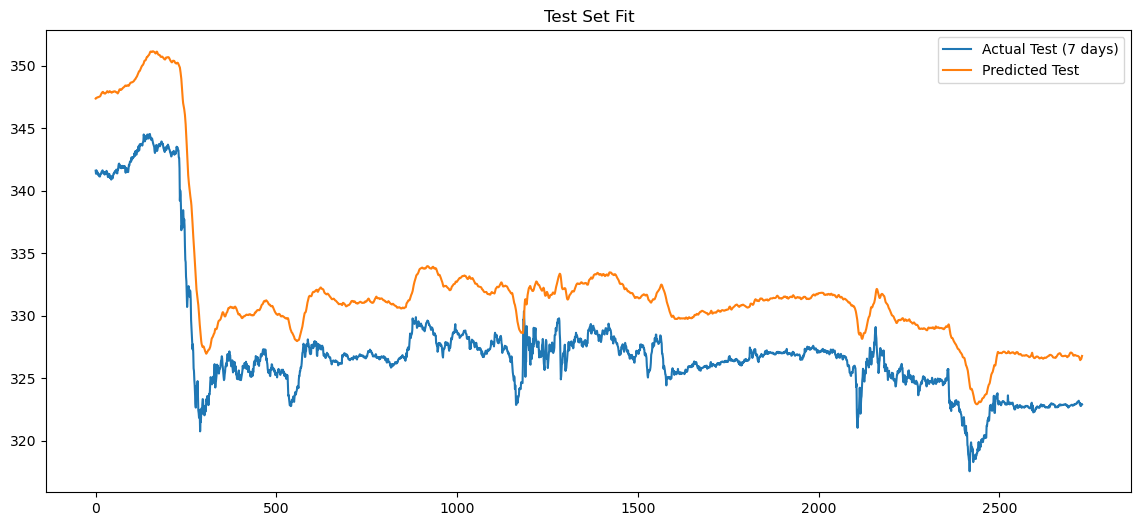

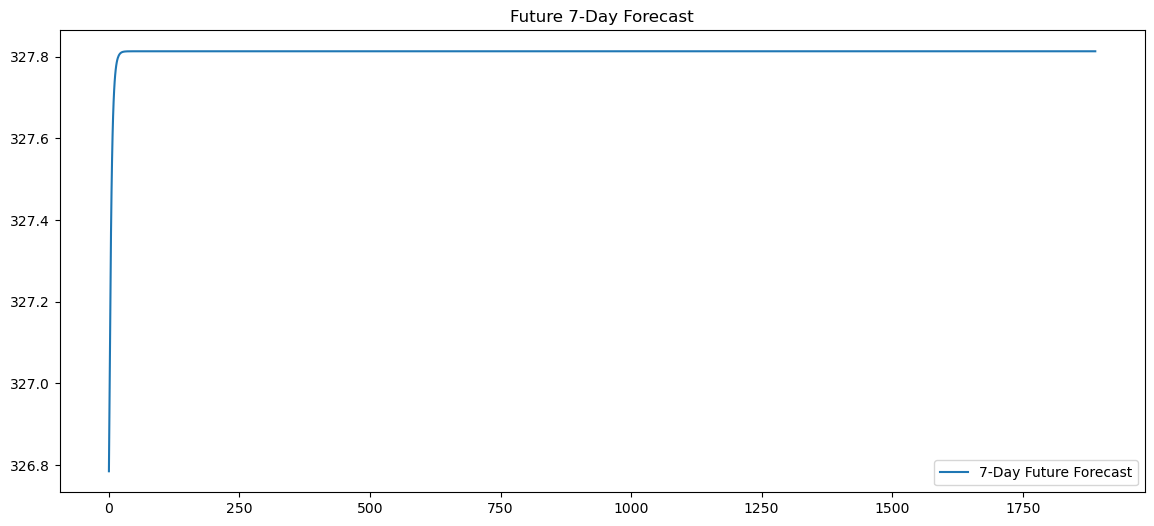

symbol NVDA
Epoch 1 Loss: 0.315279
Epoch 2 Loss: 0.215488
Epoch 3 Loss: 0.124335
Epoch 4 Loss: 0.038525
Epoch 5 Loss: 0.055165
Epoch 6 Loss: 0.036039
Epoch 7 Loss: 0.015885
Epoch 8 Loss: 0.020652
Epoch 9 Loss: 0.028087
Epoch 10 Loss: 0.030246
Epoch 11 Loss: 0.026618
Epoch 12 Loss: 0.019414
Epoch 13 Loss: 0.012218
Epoch 14 Loss: 0.009472
Epoch 15 Loss: 0.013198
Epoch 16 Loss: 0.016472
Epoch 17 Loss: 0.012286
Epoch 18 Loss: 0.006473
Epoch 19 Loss: 0.004784
Epoch 20 Loss: 0.006276
Epoch 21 Loss: 0.007752
Epoch 22 Loss: 0.007159
Epoch 23 Loss: 0.004441
Epoch 24 Loss: 0.001467
Epoch 25 Loss: 0.001224
Epoch 26 Loss: 0.003941
Epoch 27 Loss: 0.003787
Epoch 28 Loss: 0.001010
Epoch 29 Loss: 0.000757
Epoch 30 Loss: 0.002418


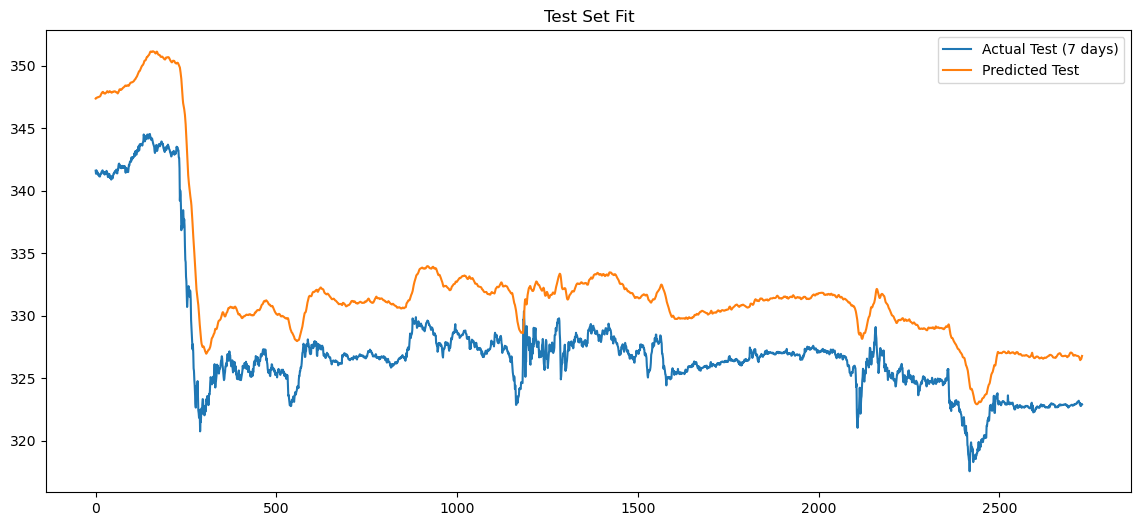

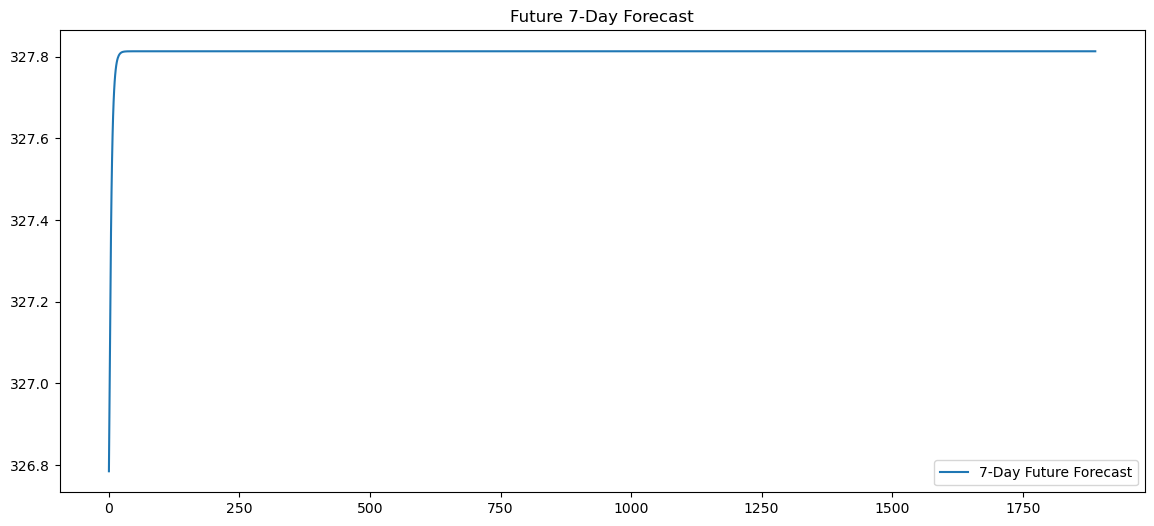

symbol TSLA


In [ ]:
for symbol in SYMBOLS:
    df = fetch_polygon_data(symbol, days=25)
    df = add_indicators(df)
    X, y = prepare_sequences(df[features], scaler, SEQ_LEN)
    makeTensors(X, y)
    train(X, y_train)
    predictFuture(model, X_test)
    inverse_transform(y_test, pred_test, future_preds)
    show(y_test_true, pred_test_true, future_true, symbol)